In [3]:
import gc
import os
import random
import time
import warnings
warnings.simplefilter("ignore")
import os
import sys
#import pdb
#import zipfile
#import pydicom
from albumentations import *
from albumentations.pytorch import ToTensor
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
import tifffile as tiff
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm_notebook as tqdm
import segmentation_models_pytorch
import matplotlib.pyplot as plt
torch.backends.cudnn.benchmark=True
sys.path.append("/home/mlrig/Documents/TFG/Code")
from utils_pipeline import *

In [4]:
def set_seed(seed=2**3):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(121)

To save time, the number of "folds" is smaller. 
These days, depending on the model, I think it's more common to use 5 ~ 10.

In [5]:
fold = 0
nfolds = 5
reduce = 4
sz = 256

BATCH_SIZE = 2
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 16
SEED = 2020
TH = 0.39  #threshold for positive predictions

DATA = '/home/mlrig/Documents/kaggle/Hubmap/test/'
LABELS = '/home/mlrig/Documents/kaggle/Hubmap/train.csv'
MASKS = '/home/mlrig/Documents/TFG/carla-simulator/out_seg_city/'
TRAIN = '/home/mlrig/Documents/TFG/carla-simulator/rgb/'


In [4]:
df = pd.DataFrame(os.listdir(TRAIN),columns=["id"])
images = []
for file in os.listdir("/home/mlrig/Documents/kaggle/Hubmap/train"):
    if file.endswith(".tiff"):
            images.append(file.split(".")[0])

In [5]:
df

,id
0,79090.png
1,80885.png
2,84983.png
3,85173.png
4,85328.png
...,...
15418,77297.png
15419,8655.png
15420,83414.png
15421,82666.png


In [6]:
images = np.array(images)
kf = KFold(n_splits=5)


In [7]:
"""# https://www.kaggle.com/iafoss/256x256-images
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self,df,classes,classes_dict,tfms):
        self.df = df
        self.tfms = tfms
        self.classes = classes
        self.classes_dict = classes_dict
        
    def __len__(self):
        return len(self.df)
    def modify_label(self,label,classes):
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if not (label[i,j] in classes):
                        label[i,j] = len(self.classes)-1
                else:      
                    label[i,j] = self.classes_dict[label[i,j]]

        return label            
    
    def __getitem__(self, idx):
        fname = self.df[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)),cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.COLOR_BGR2RGB)
        mask = np.sum(mask,axis=2)
        #mask = self.modify_label(mask,classes)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            #mask = np.sum(img,axis=2)
            
            img,mask = augmented['image'],augmented['mask']
           # print(torch.nn.functional.one_hot(img2tensor(mask).long().squeeze(0)))
        return img2tensor(img),torch.nn.functional.one_hot(img2tensor(mask).long().squeeze(0),num_classes=len(self.classes)).permute(-1,0,1).float()"""

In [8]:
classes = [142,162,-1]
classes_dict = {}
classes_dict[142] = 0
classes_dict[162] = 1
ds_t = HuBMAPDataset(df["id"],classes,classes_dict,None)
ds_v = HuBMAPDataset(df["id"],classes,classes_dict,None)
dataloader_t = torch.utils.data.DataLoader(ds_t,batch_size=1, shuffle=True,num_workers=NUM_WORKERS)
dataloader_v = torch.utils.data.DataLoader(ds_t,batch_size=1, shuffle=True,num_workers=NUM_WORKERS)
dataiter = iter(dataloader_t)
image,labels = dataiter.next()

In [9]:
"""for i, data in enumerate(dataloader_t):
    image,labels,file_name = data
    image = image
    cv2.imwrite("/home/mlrig/Documents/TFG/carla-simulator/out_seg_city/"+file_name[0],labels.numpy().reshape(600,800))"""

'for i, data in enumerate(dataloader_t):\n    image,labels,file_name = data\n    image = image\n    cv2.imwrite("/home/mlrig/Documents/TFG/carla-simulator/out_seg_city/"+file_name[0],labels.numpy().reshape(600,800))'

In [10]:
labels.shape

torch.Size([1, 3, 600, 800])

In [11]:
classes_dict[142]

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


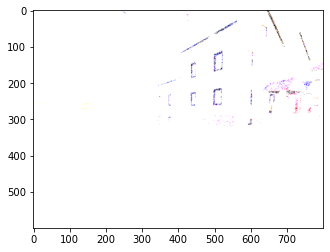

In [12]:
plt.imshow(image.squeeze().permute(1, 2, 0).numpy())

In [13]:
#plt.imshow(labels.numpy().squeeze().squeeze())
print(torch.unique(labels))

tensor([0., 1.])


In [14]:
labels.shape

torch.Size([1, 3, 600, 800])

In [15]:
 def get_aug(p=1.0):
    return Compose([
        Resize(512,512),
        HorizontalFlip(),
        #VerticalFlip(),
        #RandomRotate90(),
        #ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
        #                 border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=1),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

In [16]:
len(classes)

3

## Model

In [17]:
def get_UnetPlusPlus():
    model =  smp.Unet(
                 encoder_name='se_resnet50',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=len(classes))
    return model

## DiceLoss

Note that this loss represents 1 - DiceLoss.

In [18]:
#https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
        bce = bce_fn(y_pred, y_true)
        dice = dice_fn(y_pred.sigmoid(), y_true)
        return 0.8*bce+ 0.2*dice    

In [19]:
classes

[142, 162, -1]

## Training

In [20]:
for train_index, test_index in kf.split(df):
    fscore_max = 0
    ds_t = HuBMAPDataset(df.iloc[train_index]["id"].to_list(),classes,classes_dict,get_aug())
    ds_v = HuBMAPDataset(df.iloc[test_index]["id"].to_list(),classes,classes_dict,get_aug())
    dataloader_t = torch.utils.data.DataLoader(ds_t,batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
    dataloader_v = torch.utils.data.DataLoader(ds_t,batch_size=1, shuffle=False,num_workers=NUM_WORKERS)
    model = get_UnetPlusPlus().to(DEVICE)
    
    num_epochs = 7
    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-4}, 
        {'params': model.encoder.parameters(), 'lr': 1e-4},  
    ])
    #scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=4)
    
    #diceloss = DiceLoss()
    #loss_fn_val = segmentation_models_pytorch.utils.losses.BCEWithLogitsLoss()
    weight = torch.FloatTensor([215.39,200,0.08]).cuda()
    weight = torch.reshape(weight,(1,3,1,1))
    #mse = nn.BCEWithLogitsLoss(pos_weight=weight)
    loss_fn_val = segmentation_models_pytorch.utils.losses.BCEWithLogitsLoss(pos_weight=weight)
    #loss_fn_val = nn.CrossEntropyLoss()
    metric  = [
    segmentation_models_pytorch.utils.metrics.Fscore(),
        segmentation_models_pytorch.utils.metrics.IoU()
]
    valid_epoch = segmentation_models_pytorch.utils.train.ValidEpoch(
                model, 
                loss=loss_fn_val, 
                metrics=metric, 
                device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                verbose=False,
            )
    print(f"########FOLD: {fold}##############")
    
    for epoch in tqdm(range(num_epochs)):
        ###Train
        model.train()
        train_loss = 0
    
        for data in dataloader_t:
            optimizer.zero_grad()
            img, mask = data
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
            #print(torch.unique(mask))
            #mask = torch.nn.functional.one_hot(mask.long()).permute(0,1,4,2,3)
            print(img.shape)
            #print(mask.shape)
        
            outputs = model(img)
            #print(outputs.shape)
    
            loss = loss_fn_val(outputs,mask)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        train_loss /= len(dataloader_t)
        
        print(f"FOLD: {fold}, EPOCH: {epoch + 1}, train_loss: {train_loss}")
        
        ###Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            score_dict = valid_epoch.run( dataloader_v)
            print(score_dict)
            if score_dict["fscore"] > fscore_max:
                torch.save(model.state_dict(),f'FPN-{fold}-model.pth')
                fscore_max = score_dict["fscore"]
        """for data in dataloader_v:
            img, mask = data
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
        
            outputs = model(img)
    
            loss = diceloss(outputs, mask)
        target
            valid_loss += loss.item()
        valid_loss /= len(dataloader_v)"""
        
        #print(f"FOLD: {fold}, EPOCH: {epoch + 1}, valid_loss: {valid_loss}")
    print(fscore_max)  
        
    ###Save model
    #torch.save(model.state_dict(),f'Unet-{fold}-model.pth')

########FOLD: 0##############


torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])
torch.Size([2,

KeyboardInterrupt: 

In [ ]:
mask.permute(-1,0,1,2)

In [ ]:
x = torch.rand((1,2,244,44))
y = torch.ones((1,244,244))

In [ ]:
loss_fn_val(x,y)

In [ ]:
"""import torchvision.transforms as T
import rasterio
import pathlib
import numba
from rasterio.windows import Window
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
model.eval()
MIN_OVERLAP = 32
DATA_PATH = '/home/mlrig/Documents/kaggle/Hubmap/test/'
p = pathlib.Path(DATA_PATH)
WINDOW = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
subm = {}
print(list(p.glob('*.tiff')))

for i, filename in enumerate(p.glob('*.tiff')):
    #print(filename)
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    #print(slices)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    for (x1,x2,y1,y2) in slices:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
        image = img2tensor((image/255.0 - mean)/std)
        with torch.no_grad():
            score = model(image.to(DEVICE).unsqueeze(0)).squeeze(0).squeeze(0)
            #print(torch.max(score))
            score = score.cpu().numpy()
            score = cv2.resize(score, (WINDOW, WINDOW))
           # print(score)
            preds[x1:x2,y1:y2] = (score>0).astype(np.uint8)
            
    subm[i] = {'id':filename.stem, 'predicted': rle_numba_encode(preds)}
    del preds
    gc.collect();"""

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)
    model =  smp.FPN(
                 encoder_name='se_resnet50',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=len(classes))
def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [ ]:
submission = pd.DataFrame.from_dict(subm, orient='index')
submission.to_csv('submission.csv', index=False)

In [ ]:
submission